<center>

# [`ProxNest`](https://github.com/astro-informatics/proxnest) - __Radio Interferometry Example__ Interactive Tutorial
---
Suppose we collect complete Fourier observations $y \in \mathbb{R}^M$ of some image $x \in \mathbb{R}^N$ under a forward model $\Phi = \mathsf{G}\mathsf{F}$, where $M \ll N$ and $\mathsf{G}$ / $\mathsf{F}$ are Fourier sub-sampling and transform respectively. Suppose further that our observational instrument introduces some aleoteric uncertainty which can be adequately modelled by a univariate Gaussian $n = \mathcal{N}(0, \sigma) \in \mathbb{R}^N$. In this case our measurement equation is given by $$y = \Phi x + n.$$

Under these conditions the inverse problem of infering $x$ given $y$ is heavily degenerate and thus breaks [Hadamards](https://en.wikipedia.org/wiki/Well-posed_problem) second condition: the solution is not unique and thus the inverse problem is ill-posed. Given that inferences of $x$ are degenerate it naturally makes more sense to consider the probability distribution of possible solutions; the posterior distribution. Here we use **proximal nested sampling** ([Cai *et al* 2022](https://arxiv.org/abs/2106.03646)), which allows us to sample from this posterior distribution, recovering both an estimate of $x$ and the plausibility of this estimate. Moreover, as this is a nested sampling algorithm we automatically recover the Bayesian evidence, which naturally allows us to carry out model comparison, through which one can *e.g.* determine which forward models $\Phi$ are favoured by the data, or calibrate hyper-parameters of the problem such as $\sigma$ and regularisation parameters $\lambda$.

In [1]:
import numpy as np
import ProxNest as pxn
import ProxNest.utils as utils
import ProxNest.sampling as sampling
import ProxNest.optimisations as optimisations
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="2"


### Load an image and simulate some observations

In [2]:
# Load Image
dim = 64
ground_truth = np.load('../../data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

### Construct linear operators and mock simulated observations for our stated problem

In [3]:
np.random.seed(0)

# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)

# A wavelet dictionary in which we can promote sparsity
psi = operators.wavelet_operators.db_wavelets(["db6"], 2, (dim, dim))

In [4]:
# Simulate mock noisy observations y
y = phi.dir_op(ground_truth)
ISNR = 15
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, y.shape)

# Simulate mock noisy observations
y += n

### Define all necessary parameters and posteior lambda functions

In [5]:
# Define sampling parameters
L_likelihood = 1 / sigma**2
# Define MY lambda parameter
# lmbd = 1 / L_likelihood
lamb = 1. / L_likelihood
# Compute MY envelope Lipschitz param
L_g = 1 / lamb
# Total Lipschitz
L = L_g + L_likelihood
# Define sampling's step size
frac_delta = 1e-2
delta_step = frac_delta / L

gamma = sigma**2

print(L_likelihood)
print(lamb)
print(gamma)
print(delta_step)


0.11993289710324595
8.337995863963293
8.337995863963293
0.04168997931981647


In [33]:

delta_step_DnCNN = .01 * sigma**2
gamma_DnCNN = sigma**2
lamb_DnCNN = sigma**2

delta_step_WAV = 1e-8
lamb_WAV = 5. * delta_step_WAV
gamma_WAV = 5. * delta_step_WAV


In [34]:
# Parameter dictionary associated with optimisation problem of resampling from the prior subject to the likelihood iso-ball
params_WAV = utils.create_parameters_dict(
           y = np.copy(y),           # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = False,                # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-12,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = True,                 # Positivity flag
     reality = True                  # Reality flag
)

params_DnCNN = utils.create_parameters_dict(
           y = np.copy(y),           # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = False,                # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-12,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = True,                 # Positivity flag
     reality = True                  # Reality flag
)

# Options dictionary associated with the overall sampling algorithm
options_DnCNN = utils.create_options_dict(
    samplesL = 1e2,                  # Number of live samples
    samplesD = 1e3,                  # Number of discarded samples 
    thinning = 1e1,                  # Thinning factor (to mitigate correlations)
       delta = delta_step_DnCNN, #1e-8,    # Discretisation stepsize
       lamb = lamb_DnCNN,
        burn = 1e1,                  # Number of burn in samples
       sigma = sigma,                # Noise standard deviation of degraded image
       gamma = gamma_DnCNN,             # Gamma parameter of the prior term. Using noise variance
)

options_WAV = utils.create_options_dict(
    samplesL = 1e2,                  # Number of live samples
    samplesD = 1e3,                  # Number of discarded samples 
    thinning = 1e1,                  # Thinning factor (to mitigate correlations)
       delta = delta_step_WAV, #1e-8,    # Discretisation stepsize
       lamb = lamb_WAV,
        burn = 1e1,                  # Number of burn in samples
       sigma = sigma,                # Noise standard deviation of degraded image
       gamma = gamma_WAV,             # Gamma parameter of the prior term. Using noise variance
)


In [8]:
# # Define sampling parameters
# L_likelihood = 1. / sigma ** 2
# # Define MY lambda parameter
# lmbd = 1 / L_likelihood
# # Compute MY envelope Lipschitz param
# L_g = 1 / lmbd
# # Total Lipschitz
# L = L_g + L_likelihood
# # Define sampling's step size
# delta = 0.98 / L
# delta

In [35]:
# Regularisation parameter
delta = 1e5

# Lambda functions to evaluate cost function
LogLikeliL = lambda sol : - np.linalg.norm(y-phi.dir_op(sol))**2/(2*sigma**2)

# Lambda function for L1-norm wavelet prior backprojection steps
proxH_WAV = lambda x, T : operators.proximal_operators.l1_projection(x, T, delta, Psi=psi)


# Lambda function for L2-ball likelihood projection during resampling
proxB_WAV = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params_WAV)

# Lambda function for L2-ball likelihood projection during resampling
proxB_DnCNN = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params_DnCNN)


In [10]:
# Saved dir of the model in SavedModel format
saved_model_path = '/disk/xray0/tl3/repos/lexci_models/DnCNN/snr_15_model.pb'
# Load DnCNN denoiser prox
proxH_DnCNN = pxn.operators.learned_operators.prox_DnCNN(saved_model_path)


2023-06-19 16:36:27.289523: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 16:36:27.758785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


### Select a starting position $X_0$ and execute the sampling method

In [11]:
# Create a 'dirty image' starting position
X0 = np.abs(phi.adj_op(np.copy(y)))

In [12]:

# Perform proximal nested sampling
NS_BayEvi_WAV, NS_Trace_WAV = sampling.proximal_nested.ProxNestedSampling(
    np.copy(X0), LogLikeliL, proxH_WAV, proxB_WAV, params_WAV, options_WAV
)



ProxNest || Initialise:   0%|          | 0/200 [00:00<?, ?it/s]

ProxNest || Initialise: 100%|██████████| 200/200 [00:09<00:00, 20.31it/s]
ProxNest || Populate: 100%|██████████| 1008/1008 [00:00<00:00, 1323.03it/s]
ProxNest || Sample: 100%|██████████| 1000/1000 [01:02<00:00, 15.89it/s]
ProxNest || Compute Weights: 100%|██████████| 1000/1000 [00:00<00:00, 710898.98it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 998/998 [00:00<00:00, 1507351.60it/s]
ProxNest || Estimate Variance: 100%|██████████| 1000/1000 [00:00<00:00, 347210.60it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 1000/1000 [00:00<00:00, 380332.25it/s]


In [36]:

# Perform proximal nested sampling
NS_BayEvi_DnCNN, NS_Trace_DnCNN = sampling.proximal_nested.ProxNestedSampling(
    np.copy(X0), LogLikeliL, proxH_DnCNN, proxB_DnCNN, params_DnCNN, options_DnCNN
)


ProxNest || Initialise: 100%|██████████| 200/200 [00:09<00:00, 20.13it/s]
ProxNest || Populate: 100%|██████████| 1008/1008 [00:01<00:00, 622.37it/s]
ProxNest || Sample: 100%|██████████| 1000/1000 [00:45<00:00, 22.03it/s]
ProxNest || Compute Weights: 100%|██████████| 1000/1000 [00:00<00:00, 714532.20it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 998/998 [00:00<00:00, 1472876.63it/s]
ProxNest || Estimate Variance: 100%|██████████| 1000/1000 [00:00<00:00, 325745.88it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 1000/1000 [00:00<00:00, 350547.76it/s]


In [37]:

print(NS_BayEvi_WAV)
print(NS_BayEvi_DnCNN)


[-3.02075321e+02  2.40872206e-01]
[-2.81526864e+06  3.82166894e-01]


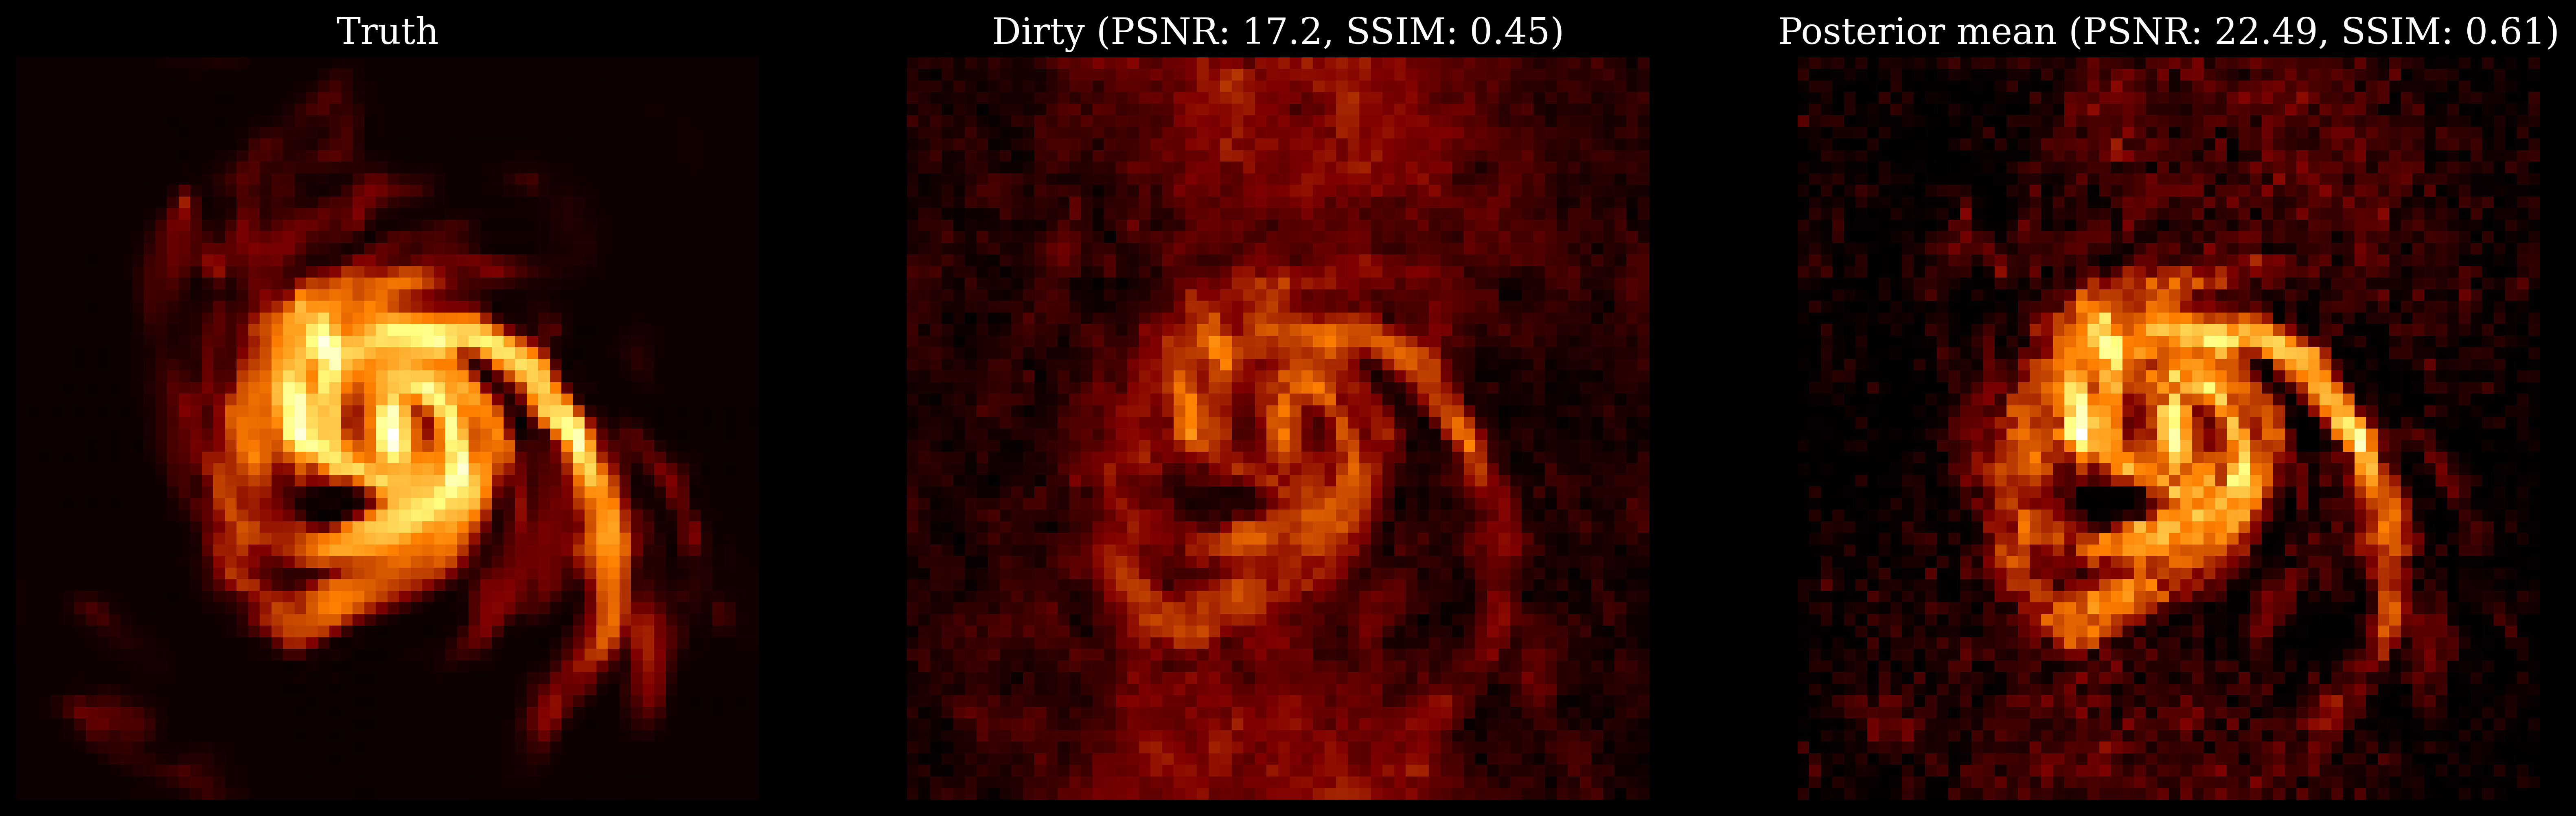

In [38]:
# WAV

images = [ground_truth, X0, NS_Trace_WAV['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()
# 27.42 -> 1e5
# 18.24 -> 5e5

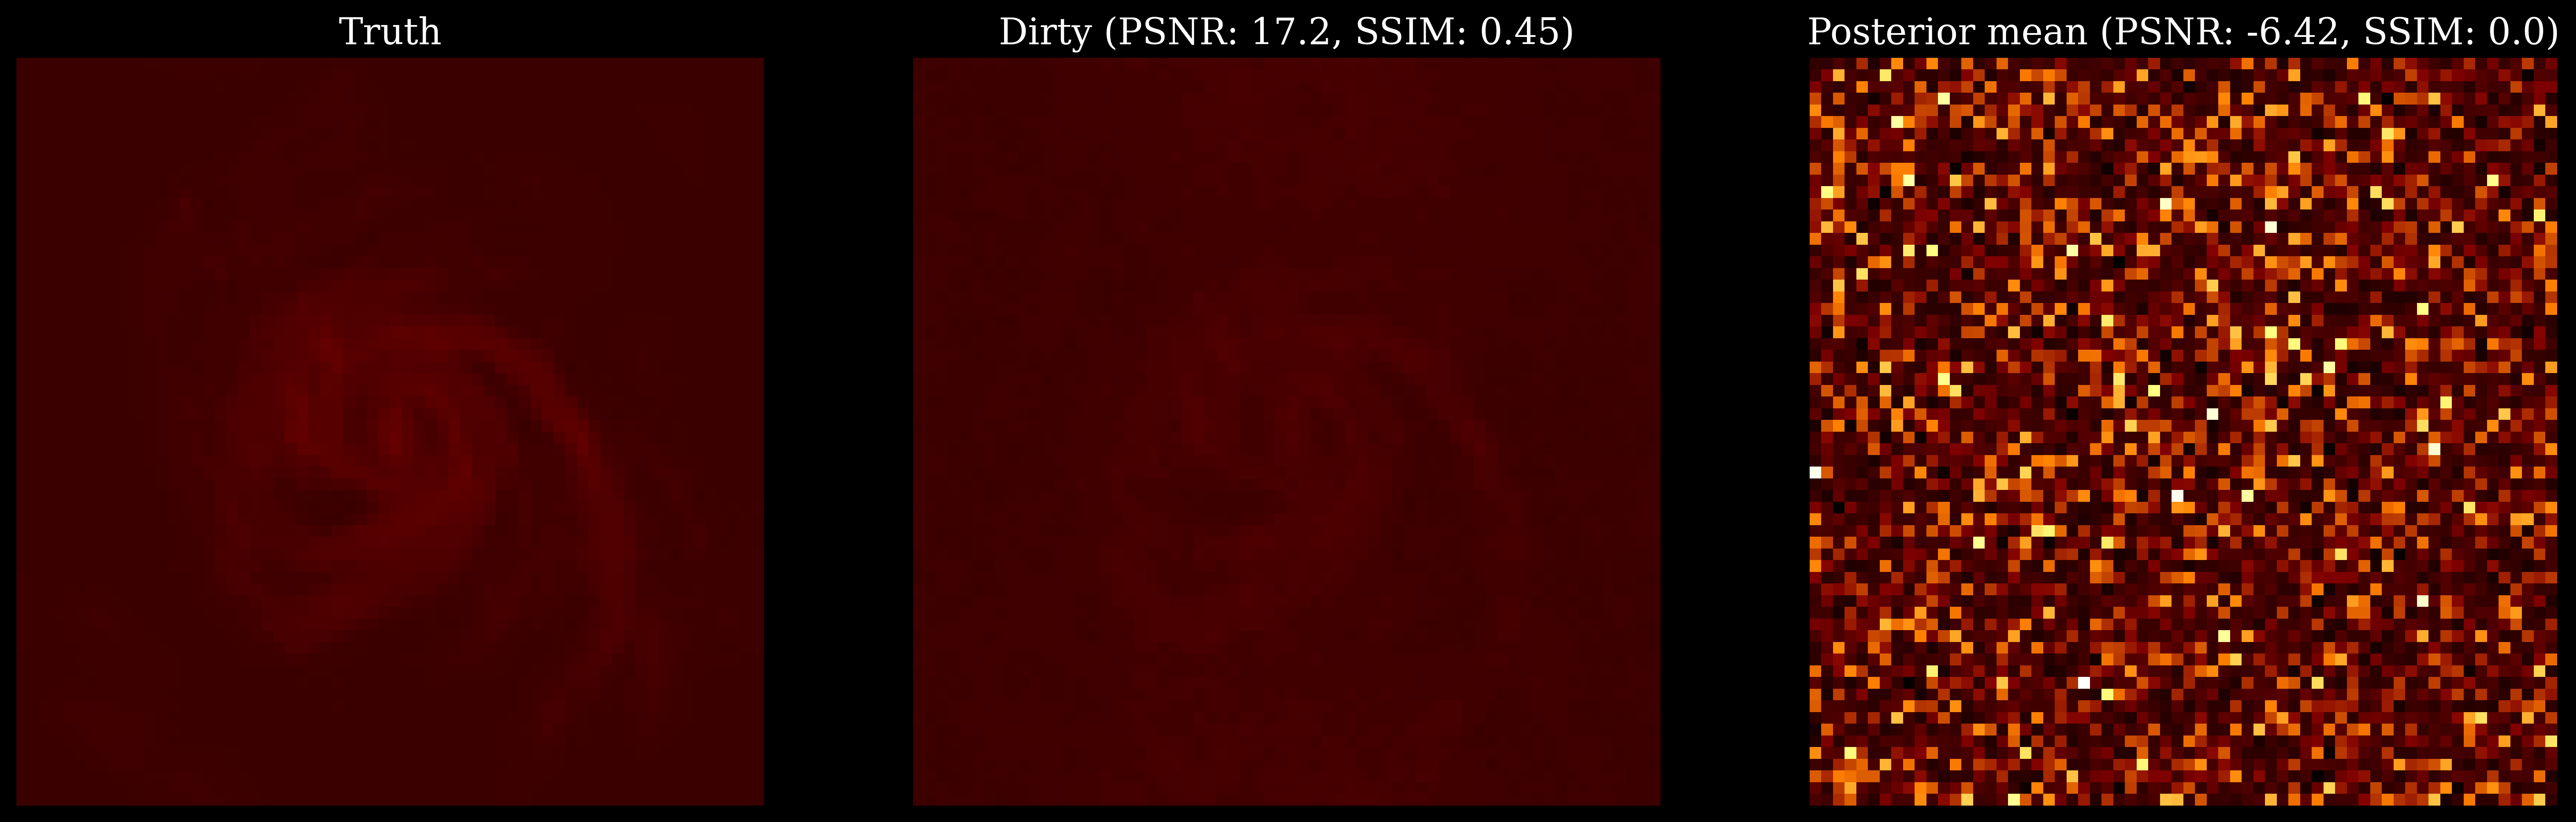

In [39]:

# DnCNN

images = [ground_truth, X0, NS_Trace_DnCNN['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
    # plt.colorbar(img=im)

plt.show()
